# TODO:
* [x] replace next two rows with sorted image names
* [x] quality control - check for missing images in both variables
* [ ] balance train_df with sklearn
* [ ] balance batches (n, n) {0, 1} with Pytorch Samplers
* [x] crop train and test images to 32 x 32 (from center)
* [x] multiply loss.item() by batch_size (because default reduction value in Loss function is mean)
* [x] replace next two rows with sorted image names
* [x] quality control - check for missing images in both variables 
* [x] make bigger batch size for validation

# Hello there!
This is my almost first try to create a notebook. The main reason for this is because I have never seen the guides, where is NN building was described

# Imports

In [1]:
import gc
import os
from collections import Counter

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
from tqdm.notebook import tqdm


Don't forget to uncomment the `DATA_DIR` constant for Kaggle or use your path instead.

In [2]:
#Constants region
# DATA_DIR = "../input/histopathologic-cancer-detection/"
DATA_DIR = "./"
TRAIN_LABELS = 'train_labels.csv'

CENTER_SIZE = 32
BATCH_SIZE = 64
VALIDATION_BATCH_SIZE = 512
#End constant region

# Data Preparation

## Import dataset

In [3]:
train_df: pd.DataFrame = pd.read_csv(DATA_DIR + TRAIN_LABELS)
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Check for duplicated values

In [4]:
print(train_df[train_df['id'].duplicated(keep=False)])

Empty DataFrame
Columns: [id, label]
Index: []


No duplicated values found.

## Check if dataset is balanced

In [5]:
Counter(train_df['label'])

Counter({0: 130908, 1: 89117})

As we can see, it is not balanced. Let's fix it. I choose to UNDERsample the dataset because I don't know how to synthesise new values for images.

In [6]:
normal = train_df.loc[train_df['label'] == 0]
malignant = train_df.loc[train_df['label'] == 1]

print(set(Counter(normal['id']).values()))
print(set(Counter(malignant['id']).values()))

{1}
{1}


In [7]:
balance_size = len(malignant)

In [8]:
normal = normal.to_numpy()
malignant = malignant.to_numpy()
print(normal.shape, malignant.shape)

(130908, 2) (89117, 2)


In [9]:
normal = normal[:balance_size, :]

In [10]:
print(set(Counter(normal[:, 0]).values()))
print(set(Counter(malignant[:, 0]).values()))

normal_and_malignant = np.insert(normal, np.arange(len(normal)), malignant, axis=0)
balanced_train_df = pd.DataFrame(normal_and_malignant, columns=['id', 'label'])

image_directory: str = os.path.join(DATA_DIR, "train")
image_names: list[str] = sorted(os.listdir(image_directory))
balanced_train_df['id'] = balanced_train_df['id'].apply(lambda x: x + '.tif')
intersected = np.intersect1d(balanced_train_df['id'].to_numpy().tolist(), image_names)

balanced_train_df = balanced_train_df[balanced_train_df['id'].isin(intersected)]
balanced_train_df['id'] = balanced_train_df['id'].apply(lambda x: os.path.join(image_directory, x))

{1}
{1}


# Implementing custom dataset

In [20]:
class HistopathologicCancerDS(Dataset):
    def __init__(self,
                 dataframe: pd.DataFrame,
                 transform=None):
        self.transform = transform
        self.labels = dataframe['label'].to_numpy()
        self.abs_image_path = dataframe['id'].to_numpy()
        print("Converting images to tensors...")
        processed_images_path = os.path.join('data', 'images.pt')
        print(f'Processed Images path: {processed_images_path}')
        if os.path.exists(processed_images_path):
            print("Loading images...")
            self.images = torch.load(processed_images_path)
        else:
            self.images = self._images_to_tensors()
            print(f"object type: {type(self.images)},\n"
                  f"object length: {len(self.images)}, \n"
                  f"object shape: {self.images.shape}")
            print("Trying to save tensor to file...")
            os.mkdir('data')
            torch.save(self.images, processed_images_path)
        print("Done")
        print("The dataset is ready for use.")

    def __len__(self):
        return len(self.abs_image_path)

    def _images_to_tensors(self):
        images = []
        for i in tqdm(range(len(self.abs_image_path))):
            with Image.open(self.abs_image_path[i]) as image:
                images.append(self.transform(image))
        return torch.stack(images)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [21]:
ds_transformer = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [22]:
dataset = HistopathologicCancerDS(dataframe=balanced_train_df, transform=ds_transformer)

Converting images to tensors...
Processed Images path: data\images.pt


  0%|          | 0/178234 [00:00<?, ?it/s]

object type: <class 'torch.Tensor'>,
object length: 178234, 
object shape: torch.Size([178234, 3, 32, 32])
Trying to save tensor to file...
Done
The dataset is ready for use.


In [23]:
print(f"dataset length: {len(dataset)}")

dataset length: 178234


In [24]:
sample, label = dataset[0]
print(sample.shape, label)

torch.Size([3, 32, 32]) 1


In [16]:
def image2plot(image) -> None:
    image = image.numpy()
    channel_last_image = np.transpose(image, (1, 2, 0))
    plt.imshow(channel_last_image)

## Splitting dataset into train and test sets

In [26]:
ds_len = len(dataset)
train_size = int(0.9 * ds_len)
validation_size = ds_len - train_size
train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
print(f"train dataset size: {len(train_ds)}, validation dataset size: {len(validation_ds)}")
print(train_ds[0])

train dataset size: 160410, validation dataset size: 17824
(tensor([[[ 1.8037,  1.6838,  1.6153,  ...,  1.5639,  1.5982,  0.9303],
         [ 0.6734,  1.5810,  1.7352,  ...,  1.1187,  0.8961,  1.2728],
         [ 1.1358,  1.0159,  2.1975,  ..., -0.3198,  0.0056,  1.2557],
         ...,
         [ 0.8447,  1.7009,  2.0948,  ...,  0.7762,  0.4508, -0.3369],
         [ 1.0502,  1.6153,  1.8550,  ..., -0.4226, -0.5082, -0.6965],
         [ 1.2899,  2.1804,  1.3584,  ..., -0.3712, -0.3712, -0.4054]],

        [[ 1.4657,  1.3081,  1.2206,  ...,  0.6429,  0.6254, -0.1099],
         [ 0.2577,  1.1856,  1.3081,  ...,  0.1702, -0.0924,  0.2402],
         [ 0.6779,  0.5378,  1.7283,  ..., -1.2654, -1.0203,  0.2227],
         ...,
         [ 0.2052,  1.0105,  1.3431,  ..., -0.1099, -0.4601, -1.2829],
         [ 0.3627,  0.8529,  1.0630,  ..., -1.1253, -1.1604, -1.3354],
         [ 0.5203,  1.3957,  0.5203,  ..., -0.8803, -0.7927, -0.7927]],

        [[ 1.7511,  1.6117,  1.5245,  ...,  1.0888,  1.1

In [18]:
train_transformation = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
validation_transformation = transforms.Compose([transforms.CenterCrop(CENTER_SIZE),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                     std=[0.229, 0.224, 0.225])
                                                ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 1


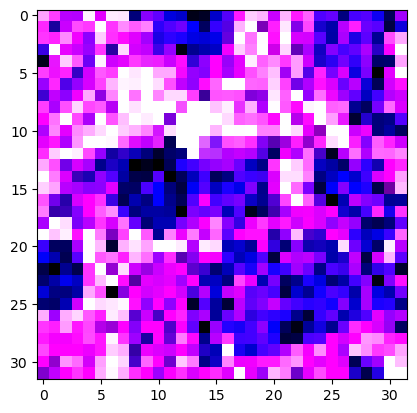

In [19]:
random_train_sample, random_train_label = train_ds[np.random.randint(0, len(train_ds))]
image2plot(random_train_sample)
print(f"label: {random_train_label}")

In [27]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)

In [33]:
for tensor, label in train_dl:
    print(tensor.view(len(tensor), -1).shape)
    print(f"label: {label}")
    break

torch.Size([64, 3072])
label: tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


# Building NN

Creating an util function to evaluate shapes after convolutions (yes, I'm so lazy)

In [73]:
def eval_shape(height, width, model, pool=0):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
            kernel_size = layer.kernel_size
            stride = layer.stride
            padding = layer.padding
            dilation = layer.dilation
            if isinstance(layer, nn.Conv2d):
                height = np.floor((height + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
                width = np.floor((width + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
            elif isinstance(layer, nn.MaxPool2d):
                height = np.floor((height + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)
                width = np.floor((width + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1)
    if pool:
        height /= pool
        width /= pool
    return int(height), int(width)

Our main neural model we will train.

In [74]:
class ConvWithReLU(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1):
        super(ConvWithReLU, self).__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)


class CD2Conv(nn.Module):
    def __init__(self):
        super(CD2Conv, self).__init__()
        self.conv_block = nn.Sequential(
            ConvWithReLU(3, 32, 7),
            ConvWithReLU(32, 64, 5)
        )
        self.relu = nn.ReLU()
        h, w = eval_shape(32, 32, self.conv_block)
        self.size = h * w
        self.fc1 = nn.Linear(64 * self.size, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [23]:
dataloaders = {
    'train': train_dl,
    'validation': validation_dl
}

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CD2Conv().to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criteria = nn.BCEWithLogitsLoss()

# NN training

In [25]:
stats = {
    'train': {
        'loss': [],
        'accuracy': []
    },
    'validation': {
        'loss': [],
        'accuracy': []
    }
}

In [26]:
def one_epoch(model,
              dataloader,
              criteria,
              optimizer=None,
              device=device):
    running_loss = 0.0
    running_accuracy = 0.0
    number_of_samples = 0
    for i, data in enumerate(tqdm(dataloader, desc='Batches')):
        x, y = data
        x = x.half().to(device)
        y = y.to(device).float()

        sample_size = x.size(0)

        if optimizer:
            optimizer.zero_grad()

        with autocast():
            output = model(x).view(len(x), -1)
            loss = criteria(output, y)
        output = torch.sigmoid(output)
        y = y.int()
        output = (output >= 0.5) * 1

        running_accuracy += torch.sum(output == y).item()
        running_loss += float(loss.item() * sample_size)
        number_of_samples += sample_size

        if optimizer:
            loss.backward()
            optimizer.step()

        if torch.cuda.is_available():
            del x, output, loss
            gc.collect()
            with torch.cuda.device(device):
                torch.cuda.empty_cache()

    loss = running_loss / len(dataloader.dataset)
    accuracy = running_accuracy / number_of_samples
    return loss, accuracy


def train(model,
          dataloaders,
          criteria,
          optimizer,
          epochs,
          stats,
          device):
    print("Epochs")
    for epoch in tqdm(range(epochs), desc="Epochs"):
        avg_train_loss, avg_train_accuracy = one_epoch(model, dataloaders['train'], criteria, optimizer)
        stats['train']['loss'].append(avg_train_loss)
        stats['train']['accuracy'].append(avg_train_accuracy)
        print(f"Training average loss - {avg_train_loss}, average accuracy - {avg_train_accuracy}")

        with torch.no_grad():
            avg_valid_loss, avg_valid_accuracy = one_epoch(model, dataloaders['validation'], criteria)
        stats['validation']['loss'].append(avg_valid_loss)
        stats['validation']['accuracy'].append(avg_valid_accuracy)
        print(f"Validation loss - {avg_valid_loss},  accuracy - {avg_valid_accuracy}")


In [27]:
train(model, dataloaders, criteria, optimizer, device=device, stats=stats, epochs=50)

Epochs


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.4985108335337268, average accuracy - 0.7663050931986783


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.46445802533647956,  accuracy - 0.7837746858168761


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.4442657590009024, average accuracy - 0.7968268811171373


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.45765722568416084,  accuracy - 0.7899461400359067


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.41425208817039016, average accuracy - 0.814057727074372


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.42309573191072614,  accuracy - 0.8098631059245961


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.38183394238528345, average accuracy - 0.8314381896390499


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.4533008541945281,  accuracy - 0.7969591561938959


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.3432628141545081, average accuracy - 0.8515865594414314


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.4410030080985338,  accuracy - 0.806609066427289


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.29605176185206816, average accuracy - 0.8778941462502338


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.46640510201668184,  accuracy - 0.8006620287253142


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.24259970114178495, average accuracy - 0.9045321364004738


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.5048448279687275,  accuracy - 0.7917414721723519


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.18642172184865394, average accuracy - 0.932011719967583


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.5521232419424896,  accuracy - 0.7949955116696589


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.14045187257433256, average accuracy - 0.9514992830870893


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.6397501179945105,  accuracy - 0.7960053859964094


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.10429914517253944, average accuracy - 0.9654260956299483


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.7164580095392156,  accuracy - 0.7915170556552962


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.07917632235121336, average accuracy - 0.9745527086839972


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.8158650503124326,  accuracy - 0.785177289048474


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.06395143009836028, average accuracy - 0.9800511190075432


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.9008094742225359,  accuracy - 0.7897778276481149


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.050952696133251464, average accuracy - 0.9845146811296054


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.9939860289571957,  accuracy - 0.7816427289048474


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.04308083526133844, average accuracy - 0.9869147808740103


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.0751001824168371,  accuracy - 0.7888240574506283


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.03856921569372188, average accuracy - 0.9883299046194127


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.1014119155531084,  accuracy - 0.7842796229802513


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.03543155034073336, average accuracy - 0.9893709868462066


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.1475415244778782,  accuracy - 0.7855139138240574


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.03180304438016947, average accuracy - 0.9902873885667975


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.2232741746697007,  accuracy - 0.7862432675044884


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.030613047728736156, average accuracy - 0.9905492176298236


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.2564841960448123,  accuracy - 0.7863554757630161


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.02787794155774053, average accuracy - 0.9913783429960725


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.3320661909490341,  accuracy - 0.7757517953321365


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.026001509815894802, average accuracy - 0.9924256592481765


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.3510114988261963,  accuracy - 0.7733954219030521


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.025204239713678217, average accuracy - 0.9921014899320492


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.2938344063407856,  accuracy - 0.7630722621184919


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.023779822011762677, average accuracy - 0.9926313820834113


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4627092462467761,  accuracy - 0.7758078994614004


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.023193818821623614, average accuracy - 0.9929617854248488


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4224729032876033,  accuracy - 0.7771543985637342


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.022602215211626104, average accuracy - 0.9930739978804314


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4227733995156828,  accuracy - 0.7763128366247756


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.020838597496313914, average accuracy - 0.993709868462066


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4419373205363002,  accuracy - 0.779286355475763


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.019254637611617113, average accuracy - 0.9942148245121876


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4346644043708403,  accuracy - 0.7678411131059246


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.020915760312807195, average accuracy - 0.9934293373231096


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4279378449253377,  accuracy - 0.7728904847396768


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.018130269354358748, average accuracy - 0.9945389938283149


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.5066919076378513,  accuracy - 0.7704219030520646


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.018407438183281718, average accuracy - 0.99432080294246


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.566925979174232,  accuracy - 0.7765372531418312


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.018740740929526507, average accuracy - 0.9942397606134281


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.47253846009287,  accuracy - 0.779286355475763


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.017102883163277918, average accuracy - 0.9948880992456829


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.5453898399479726,  accuracy - 0.7749663375224417


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.016276717639739143, average accuracy - 0.995112524156848


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6332485329098934,  accuracy - 0.7755273788150808


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.016072429254936196, average accuracy - 0.9949753756000249


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.600509268377157,  accuracy - 0.7808011669658886


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01568220874701733, average accuracy - 0.9951374602580887


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8652247736227148,  accuracy - 0.774685816876122


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.016054078530553642, average accuracy - 0.995106290131538


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6619046220231528,  accuracy - 0.7733393177737882


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.014806253894623646, average accuracy - 0.9954553955489059


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7248533640986499,  accuracy - 0.7733393177737882


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.014468374403025105, average accuracy - 0.9956237142322798


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8030835049798715,  accuracy - 0.7751346499102334


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.015099928012797845, average accuracy - 0.9954553955489059


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.720333944745295,  accuracy - 0.776705565529623


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013748228748864113, average accuracy - 0.9959229474471666


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7481420436068111,  accuracy - 0.7750785457809695


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01459563936248205, average accuracy - 0.9954865656754567


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.720964283232629,  accuracy - 0.7684582585278277


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.012833183594560538, average accuracy - 0.9960538619786796


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7811413763669492,  accuracy - 0.7639138240574507


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01310194043130134, average accuracy - 0.9960663300292999


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.858366853458877,  accuracy - 0.7667190305206463


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013915669283803271, average accuracy - 0.9957483947384826


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9187872752252986,  accuracy - 0.7707024236983842


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013248868737167643, average accuracy - 0.9959915217255783


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9211568267383952,  accuracy - 0.7805206463195691


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013005955973032498, average accuracy - 0.9958481391434449


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8197647183330954,  accuracy - 0.7765933572710951


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.012403340601649621, average accuracy - 0.9962533507886042


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 2.081087594828443,  accuracy - 0.7732271095152603


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01225609118002456, average accuracy - 0.9961847765101927


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9273634303622014,  accuracy - 0.7765933572710951


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013805500324055258, average accuracy - 0.9956860544853812


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9819388702056995,  accuracy - 0.7744052962298025


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010765461136077091, average accuracy - 0.9968455831930678


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8941944189088777,  accuracy - 0.7687948833034112


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01189369089351499, average accuracy - 0.996247116763294


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.942280463727201,  accuracy - 0.7729465888689407


In [28]:
def fetch_json(path: str) -> dict:
    with open(path, "r") as file:
        json_file = json.load(file)
        file.close()
    return json_file


def save_json(json_dict: dict, path: str):
    with open(path, "w") as file:
        json.dump(json_dict, file)
        file.close()

In [29]:
result_dict = {model.__class__.__name__: stats}
save_json(result_dict, "stats.json")

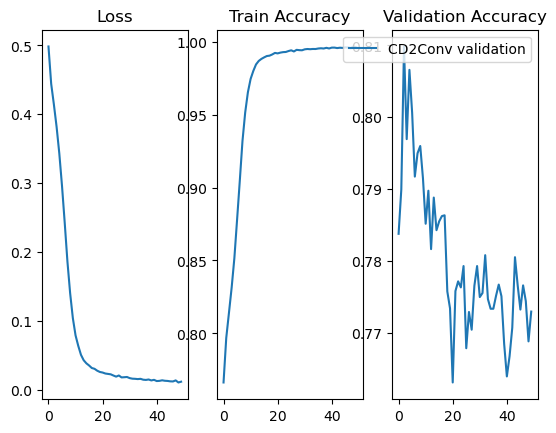

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
for k, v in result_dict.items():
    ax1.plot(v["train"]["loss"], label=f"{k} train")

    ax2.plot(v['train']['accuracy'], label=f'{k} train')
    ax3.plot(v['validation']['accuracy'], label=f'{k} validation')

ax1.set_title('Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Validation Accuracy')
plt.legend()
plt.show()


In [31]:
torch.save(
    {
        'epochs': 50,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    },
    os.path.join("weights", f'{model.__class__.__name__}.pt'))

We trained this model but as we can see, the model performs not so well on validation set.
Next thing we should do is to fix it. There are a few options - take the model and fully retrain it with new (augmented data) or try to train only on augmented data.
I choose the last.

# Improving NN
Loading trained model

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load(os.path.join("weights", "CD2Conv.pt"))
model = CD2Conv().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criteria = nn.BCEWithLogitsLoss()

Define another data transformations for the dataset.

In [33]:
augmented_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(p=0.4),
        transforms.RandomRotation(degrees=45),
        transforms.CenterCrop(CENTER_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])

    ]
)

In [34]:
dataset = HistopathologicCancerDS(balanced_train_df, transform=augmented_transforms)

Converting images to tensors...


  0%|          | 0/178234 [00:00<?, ?it/s]

The dataset is ready for use.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: 0


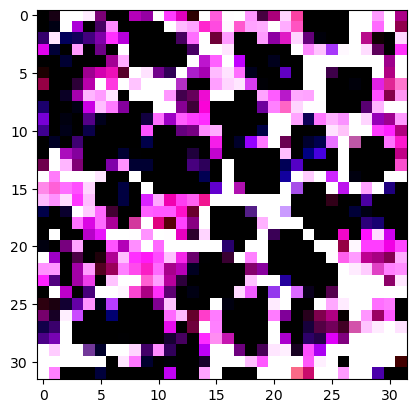

In [35]:
random_sample = dataset[np.random.randint(0, len(dataset))]
print(f"label: {random_sample[1]}")
image2plot(random_sample[0])

In [36]:
ds_len = len(dataset)
train_size = int(0.9 * ds_len)
validation_size = ds_len - train_size
train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=VALIDATION_BATCH_SIZE, shuffle=True)
dataloaders = {
    'train': train_dl,
    'validation': validation_dl
}

stats = {
    'train': {
        'loss': [],
        'accuracy': []
    },
    'validation': {
        'loss': [],
        'accuracy': []
    }
}

In [37]:
train(model, dataloaders, criteria, optimizer, epochs=50, stats=stats, device=device)

Epochs


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.4616522461107177, average accuracy - 0.7958543731687551


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.42207829501727323,  accuracy - 0.809245960502693


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.38890310485875335, average accuracy - 0.8256717162271678


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.4152240875165381,  accuracy - 0.8136781867145422


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.33218655948418646, average accuracy - 0.855719718222056


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.424630763233243,  accuracy - 0.8098631059245961


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.2503094063967617, average accuracy - 0.8985350040521165


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.4800647866362087,  accuracy - 0.8039160682226212


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.15904305391917017, average accuracy - 0.9433514120067328


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.5499018559122,  accuracy - 0.7977446140035906


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.08718518022196778, average accuracy - 0.9743095816969017


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.6818579404315572,  accuracy - 0.7873653500897666


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.04808601540878585, average accuracy - 0.9874446730253725


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.8058381887483853,  accuracy - 0.7855139138240574


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.03217463021189092, average accuracy - 0.9917586185399913


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.964031009100498,  accuracy - 0.7887679533213644


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.025485477064400085, average accuracy - 0.9932672526650458


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 0.9925345285148552,  accuracy - 0.7869165170556554


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.02366567764209279, average accuracy - 0.9934729755002806


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.0999235658500095,  accuracy - 0.7889923698384201


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.020709823891202336, average accuracy - 0.9942023564615672


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.1505071699512284,  accuracy - 0.7638577199281867


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01807495513615657, average accuracy - 0.9948818652203728


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.134824582875524,  accuracy - 0.7796229802513465


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.017498884474919953, average accuracy - 0.9949255033975438


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4066120608704737,  accuracy - 0.7905071813285458


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01764044659605871, average accuracy - 0.9949317374228539


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.228731991786717,  accuracy - 0.7839991023339318


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01350658589856012, average accuracy - 0.9961224362570912


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.2561344327789663,  accuracy - 0.7802401256732495


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.015664738071674247, average accuracy - 0.9954553955489059


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.3624875427790561,  accuracy - 0.7745175044883303


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01335821589203033, average accuracy - 0.9961910105355027


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.2519061871448154,  accuracy - 0.7754712746858169


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013344848867112498, average accuracy - 0.9961847765101927


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4188213095844755,  accuracy - 0.7786131059245961


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.013331421031109484, average accuracy - 0.9960600960039898


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.5443453016144155,  accuracy - 0.78125


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.012048729452322018, average accuracy - 0.9966024562059722


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.5255396663607559,  accuracy - 0.776032315978456


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01269795070223793, average accuracy - 0.9963717972694969


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.647774617590639,  accuracy - 0.7781642728904847


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.011691810689759077, average accuracy - 0.9964777756997694


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4394424824141085,  accuracy - 0.7724416517055656


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.01216163070496698, average accuracy - 0.9965214138769404


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4763927123704976,  accuracy - 0.7790619389587073


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010381127379629675, average accuracy - 0.9969827317498909


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4970417178939874,  accuracy - 0.7742930879712747


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.011680216855692257, average accuracy - 0.9965712860794215


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.64127031305748,  accuracy - 0.7833819569120287


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010899059969536887, average accuracy - 0.996677264509694


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.619433862516653,  accuracy - 0.7754712746858169


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.011704994616816223, average accuracy - 0.9966710304843838


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6903808303110475,  accuracy - 0.769524236983842


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009885446001560832, average accuracy - 0.9971136462814039


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.601892235677161,  accuracy - 0.7790058348294434


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010630359711791515, average accuracy - 0.9968455831930678


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6270661814208518,  accuracy - 0.7776032315978456


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010144646753986103, average accuracy - 0.9968705192943084


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.5518787853165632,  accuracy - 0.774741921005386


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009486253377547204, average accuracy - 0.9972133906863662


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.451180160366654,  accuracy - 0.7690754039497307


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.010250970930817066, average accuracy - 0.9968829873449286


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.4183931834393815,  accuracy - 0.7645309694793537


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.011256099361506261, average accuracy - 0.9965463499781809


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6465263186922192,  accuracy - 0.7641382405745063


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008615041776742494, average accuracy - 0.9973754753444299


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7816541152111718,  accuracy - 0.7814744165170556


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009834114255650797, average accuracy - 0.9970887101801633


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.6359587513993843,  accuracy - 0.7671117594254937


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008894329569619719, average accuracy - 0.9972819649647777


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8361013286631669,  accuracy - 0.7680094254937163


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009228959550679467, average accuracy - 0.9971759865345053


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8382260412031273,  accuracy - 0.7745736086175943


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009192796917530329, average accuracy - 0.9970637740789228


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7535590562614976,  accuracy - 0.7698047576301615


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008623930471490397, average accuracy - 0.9974004114456705


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8579239504983651,  accuracy - 0.7741808797127468


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009479961933097815, average accuracy - 0.9970824761548532


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.916424049723298,  accuracy - 0.7722172351885098


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.00870070103752828, average accuracy - 0.9973193691166387


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9063412862791407,  accuracy - 0.7643626570915619


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008241224308652872, average accuracy - 0.9974876878000125


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.858130331527395,  accuracy - 0.7695803411131059


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.0088710040997973, average accuracy - 0.9973505392431893


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7566708478294113,  accuracy - 0.7621745960502693


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008065554881915977, average accuracy - 0.9974939218253226


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8198906859546846,  accuracy - 0.7740125673249552


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.008155688539966632, average accuracy - 0.9974627516987719


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.7759221222927155,  accuracy - 0.7709829443447038


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.0087270021227531, average accuracy - 0.9973505392431893


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 2.122827203312297,  accuracy - 0.7744052962298025


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.00665587201164776, average accuracy - 0.9978804313945515


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.91607741735996,  accuracy - 0.7632966786355476


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.009293440607829523, average accuracy - 0.9971448164079546


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.9411097264161443,  accuracy - 0.7726660682226212


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.007402426314359234, average accuracy - 0.997687176609937


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 2.0129061192541617,  accuracy - 0.7639138240574507


Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

Training average loss - 0.007880162482852377, average accuracy - 0.9974378155975313


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Validation loss - 1.8827781244925152,  accuracy - 0.7650359066427289


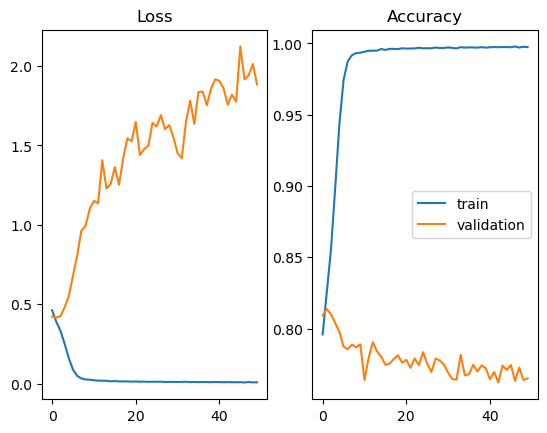

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(stats["train"]["loss"], label='train')
ax1.plot(stats['validation']['loss'], label='validation')
ax2.plot(stats['train']['accuracy'], label='train')
ax2.plot(stats['validation']['accuracy'], label='validation')

ax1.set_title('Loss')
ax2.set_title('Accuracy')
plt.legend()
plt.show()


In [42]:
torch.save(
    {
        'epochs': 50,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    },
    os.path.join("weights", f'{model.__class__.__name__}1.pt')
)

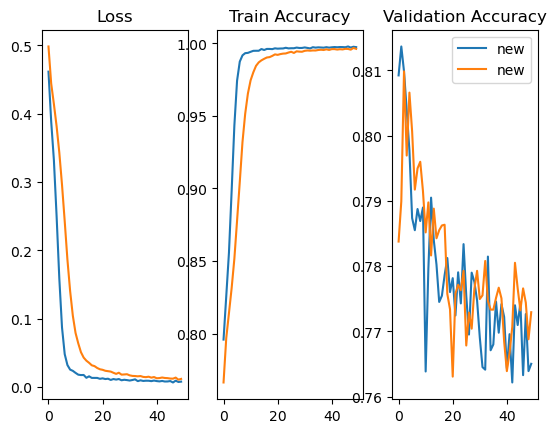

In [44]:
old_stats = fetch_json('stats.json')['CD2Conv']
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
ax1.plot(stats["train"]["loss"], label='new')
ax1.plot(old_stats['train']['loss'], label='old')
ax2.plot(stats['train']['accuracy'], label='new')
ax2.plot(old_stats['train']['accuracy'], label='old')
ax3.plot(stats['validation']['accuracy'], label='new')
ax3.plot(old_stats['validation']['accuracy'], label='new')

ax1.set_title('Train Loss')
ax2.set_title('Train Accuracy')
ax3.set_title('Validation Accuracy')
plt.legend()
plt.show()


In [75]:
checkpoint = torch.load(os.path.join("weights", "CD2Conv1.pt"))
model = CD2Conv().to(device)
model.load_state_dict(checkpoint['model_state_dict'])

result size: (22, 22)


<All keys matched successfully>

In [78]:
for i, data in enumerate(tqdm(train_dl, desc='Batches')):
    x, y = data
    x = x.half().to(device)
    print(x.shape)
    y = y.to(device).float()

    sample_size = x.size(0)
    with torch.no_grad():
        with autocast():
            output = model(x).view(len(x), -1)
        output = torch.sigmoid(output)
        output = (output >= 0.5) * 1
    break

Batches:   0%|          | 0/2507 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])
flatten: torch.Size([64, 30976])


In [ ]:
submission_list = []
for filename in tqdm(os.listdir('test')):
    with Image.open(os.path.join('test', filename)) as img:
        print(type(img))
        tensor = ds_transformer(img).half().to(device).reshape(1, 3, 32, 32)
        print(type(tensor))
        print(tensor.shape)
    with autocast():
        with torch.no_grad():
            output = model(tensor).reshape(-1)
        output = torch.sigmoid(output)
        label = (output >= 0.5) * 1
    submission_list.append([filename[:-4], label])

In [87]:
submission_list = [(i[0], int(i[1][0])) for i in submission_list]

In [100]:
submission_pd = pd.DataFrame(submission_list, columns=['id', 'label'])
submission_pd = submission_pd.set_index('id')

In [101]:
submission_pd.to_csv('submission.csv')